# Fourier transform Mass Spectrometry

---
## Before Class
1. Review Mass Spectrometry
* Review Fourier Transform

---
## Learning Objectives
1. Implement discrete fourier transform
* Transform Mass Spectrometry data


---
## Peptide Analysis

In class today we will implement computational simulation of a mass spectrum analysis. This will involve generating the b and y ions from a peptide and estimating their mass. We will then plot their spectrum and build a function to estimate maximum multiplicity of the sample.

After this we will implement a discrete fourier transform. This algorithm is used for analysis of Fourier Transform Ion Cyclotron Resonance Mass Spectrometry (FTMS), which is a commonly used application for MS in machines. This method is able to build a m/z spectrum from peptides input into the machine.


In [1]:
# Relevant masses for amino acids, H+, and water
H_ion = 1.00728
water = 18.01056

amino_acid_table = {
      'A' : 71.03711,
      'R' : 156.10111,
      'N' : 114.04293,
      'D' : 115.02694,
      'C' : 103.00919,
      'E' : 129.04259,
      'Q' : 128.05858,
      'G' : 57.02146,
      'H' : 137.05891,
      'I' : 113.08406,
      'L' : 113.08406,
      'K' : 128.09496,
      'M' : 131.04049,
      'F' : 147.06841,
      'P' : 97.05276,
      'S' : 87.03203,
      'T' : 101.04768,
      'W' : 186.07931,
      'Y' : 163.06333,
      'V' : 99.06841,
      'X' : 0.00000     #  for unknown amino acids
      } # dictionary of amino acids 'aa' and their monoisotopic mass

Recall from the slides that the y-ion and b-ion are defined for all prefix and suffix strings of a peptide as follows

```
b_ion = AA mass + H+
y_ion = AA_mass + H+ + Water
```


In [2]:
def calc_yion_mass(y_ion):
    ''' Function to estimate y-ion mass
    y ion mass is the sum of the masses of the amino acids in a peptide plus H+ and water
    
    Args:
        y_ion (str): amino acid string
        
    Returns:
        mass (float): Mass of ion
    '''
    mass = water + H_ion
    for aa in y_ion:
        mass += amino_acid_table[aa]
    
    return mass

def calc_bion_mass(b_ion):
    ''' Function to estimate b-ion mass
    b ion mass is the sum of the masses of the amino acids in a peptide plus H+
    
    Args:
        b_ion (str): amino acid string
        
    Returns:
        mass (float): Mass of ion
    '''
    mass = H_ion
    for aa in b_ion:
        mass += amino_acid_table[aa]
    
    return mass

def theoretical_spectrum(peptide_sequence):
    ''' Function to generate theoretical spectrum of a peptide
    Calculates a list of b ions and y ions 
    
    Args:
        peptide_sequence (str): amino acid string
        
    Returns:
        mass_peaks (list of floats): Masses generated by ions of peptide
    '''
    mass_peaks = []
    for position in range(1,len(peptide_sequence)):
        mass_peaks.append(calc_bion_mass(peptide_sequence[:position]))
        mass_peaks.append(calc_yion_mass(peptide_sequence[position:]))
    return mass_peaks

In [3]:
theoretical_spectrum('APNDFNLK')

[72.04438999999999,
 847.43083,
 169.09715,
 750.37807,
 283.14008,
 636.33514,
 398.16702,
 521.3082,
 545.23543,
 374.23978999999997,
 659.2783599999999,
 260.19686,
 772.3624199999999,
 147.1128]

---
## Plot Spectrum

Next we will plot the theoretical spectrum as shown below:

<img src="figures/spectrum.png">

In [4]:
import matplotlib.pyplot as plt

def plot_spectrum(mass_spectrum):
    ''' Function to plot theoretical mass spectrum
    
    Args:
        mass_peaks (list of floats): Masses generated by ions of peptide
        
    '''
    y_vals = [.3] * len(mass_spectrum)
    fig=plt.figure()
    fig1=fig.add_subplot(111)
    fig1.set_xlim([0,900])
    fig1.set_ylim([0,1])
    fig1.bar(mass_spectrum, y_vals, 5)
    fig1.set_xlabel("m/z") #some axis labeling
    fig1.set_ylabel("abundance") #some axis labeling
    fig1.set_title("Theoretical Spectrum") #some title labeling



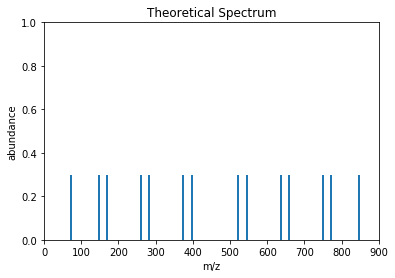

In [5]:
plot_spectrum(theoretical_spectrum('APNDFNLK'))

---
## Score a spectrum

Next we will write a function to score a spectrum against another. This will be useful to compare a real measured spectrum against a database of theoretical spectra to find matches. While there are multiple ways to score these, we will score as a ratio of the matching peak intensities of the measured spectra scaled by the total of all peaks in the spectra. Another common scoring criteria is maximum multiplicity which results in the spectrum with the most similarity.

```
score_spectrum:
    if peaks match:
        score += height
        
    return score / sum(score)
```


In [6]:
def score_spectrum(real_spectrum_peaks, real_spectrum_heights, theoretical_spectrum):
    ''' Function to compare to spectra and score as a ratio of spectrum explained
    
    Args:
        real_spectrum (list of floats): Masses generated by ions of peptide
        theoretical_spectrum (list of floats): Masses generated by ions of peptide
        
    Returns:
        score (float): fraction of theoretical spectrum explained

    '''
    
    score = 0
    for i, peak in enumerate(real_spectrum_peaks):
        if peak in theoretical_spectrum:
            score += real_spectrum_heights[i]
            
    score = score / sum(real_spectrum_heights)
    return score

In [7]:
real_spectrum_peaks = [72.04438999999999, 751.37807, 283.14008, 636.33514, 545.23543, 240.19686, 772.3624199999999, 147.1128]
real_spectrum_heights = [.2, .1, .05, .05, .1, .1, .2, .2]
score_spectrum(real_spectrum_peaks, real_spectrum_heights, theoretical_spectrum('APNDFNLK'))

0.8

---
## Fourier Transform for Mass spectrometry analysis


A Fourier Transform will break apart a time signal and will return information about the frequency of all sine waves needed to simulate that time signal. For sequences of evenly spaced values the Discrete Fourier Transform (DFT) is defined as:

$X_k = \sum_{n=0}^{N-1}x_n  e^{-2 \pi ikn/N}$

Where $N$ = number of samples; $n$ = current sample; $x_{n}$ = value of the signal at time $n$; $i$ = imaginary number $i$; $k$ = current frequency ($0$ Hz to $N-1$ Hz); $X_{k}$ = Result of the DFT (amplitude and phase)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

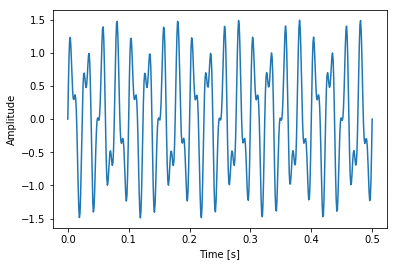

In [3]:
# Here we generate an example signal by combining two sine waves at 40 and 90 Hz
time_points = np.linspace(0, 0.5, 500) # Sampling frequency of 500 samples over 0.5 seconds

signal = np.sin(40 * 2 * np.pi * time_points) + 0.5 * np.sin(90 * 2 * np.pi * time_points)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(time_points, signal)
plt.show()

In [4]:
def discrete_fourier_transform(signal):
    """ Function to compute discrete fourier transform of a series
    
    Args:
        signal (np array): array of signal values over time
        
    Returns:
        amplitudes (np array): array of amplitudes at frequencies
    
    """
    N = signal.size
    
    X = np.zeros((N,), dtype=complex)

    
    for k in range(N):
        sum = 0
        for n in range(N):
            sum += signal[n]*np.exp(-2*np.pi*1j*k*n/N)
        X[k] = sum
    return X
    

In [6]:
# Using the above function, we can transform from time to frequency
dft = discrete_fourier_transform(signal)

## Plotting fourier transform

The above function will transform our data from time to frequency. 

The frequency output from the fourier transform is reported at intervals $1/(N*T)$ where $T$ is the sampling interval in our original data and N is the number of samples (for example, above this would be $1/(500 * .001) = 2$.

A limitation of this calculation is that we can only observe frequency up to the Nyquist frequency defined as half of the rate of the discrete signal:

$ 0 <= f <= 1/2T$

At the nyquist frequency the data folds back and is repeated in inverse (ie. `X[0] == X[N-1]`).

For our practical purposes, this means that we can only plot the first half of the data.

Below plot frequency and amplitude generated by the dft as shown in the example:

<img src="figures/dft_plot.png">

In [7]:
def plot_dft(T, N, dft):
    """ Function to compute plot discrete fourier transform of a series
    
    Args:
        T (float): sampling interval
        N (int): number of samples in interval
        dft (np array): DFT of sample data
        
    Plots frequency by amplitude
    
    """

    # 1/T = frequency
    frequency = np.linspace(0, 1 / T, N)
    # Observable frequency is just the first half
    obs_frequency = frequency[:N//2] # // is the floor function to handle python floating point errors


    # Next we scale the absolute value fourier transform by the number of observations
    dft_scaled = np.abs(dft) * 1/N
    # And again, we only observe the first half
    obs_dft = dft_scaled[:N//2]

    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
    plt.bar(obs_frequency, obs_dft, width=2)

    plt.show()



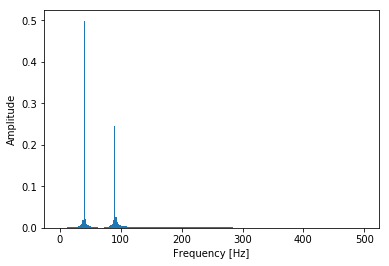

In [8]:
T = time_points[1] - time_points[0]  # sampling interval 
N = signal.size
plot_dft(T, N, dft)

## Transform FTMS data

Below we have provided a digital sample from FTMS as a numpy array. This data was sampled 1000 times over 0.5 seconds. Use the above tools to transform the data.


In [12]:
ftms_data = np.array([-9.22291358e-03,  1.07584649e-02, -7.62767701e-03, -1.19309407e-02,
        1.11279672e-02, -8.41564787e-04, -1.18543193e-02, -3.16746827e-03,
       -1.12390096e-02,  1.25813138e-02,  8.82389293e-03,  3.84384065e-03,
        2.50739406e-03, -6.48580386e-03,  6.88247030e-03,  1.65803808e-02,
       -1.94409337e-02, -9.35906901e-03,  1.53388445e-02, -1.30356410e-02,
       -1.01361599e-02, -1.20042594e-03,  1.26722795e-02,  4.58550855e-03,
       -1.73695747e-02,  1.72052729e-03,  2.84363306e-02, -3.73595674e-03,
       -4.53809772e-03,  7.69437431e-03, -1.10729131e-02, -6.58815982e-03,
       -1.29144853e-03,  2.83338657e-03,  3.32423233e-03, -1.03056849e-02,
       -6.42547599e-03,  6.42695256e-03, -1.00503604e-03,  8.80040796e-03,
        1.53703519e-02, -5.51151609e-03, -2.35776352e-04, -4.68046967e-03,
       -7.02208386e-03,  6.10734570e-03,  4.12377384e-03, -7.99223732e-03,
       -1.05413197e-02, -4.18972261e-03,  1.00861088e-02,  2.85239055e-03,
       -1.22046687e-02,  1.94570543e-02,  1.08021978e-02, -1.20390382e-02,
       -5.41241151e-03,  1.08277492e-02,  3.27203390e-03, -9.90829002e-03,
       -1.40467278e-02,  8.79365249e-03,  6.22297164e-03, -1.63306372e-02,
        2.75971574e-03,  4.83520590e-03, -1.40830319e-03,  8.00427711e-03,
        8.32727713e-03, -1.90306047e-03,  2.49182416e-03, -7.20076124e-03,
       -3.58936676e-03,  1.05208588e-03, -3.28665944e-03,  8.13509420e-03,
       -5.92740004e-03, -1.65413568e-02,  4.45125055e-03,  6.63479487e-03,
        2.44878521e-03,  1.30480689e-02,  2.17713459e-03, -7.76802107e-03,
       -3.64760177e-03, -1.89618944e-03,  1.05304989e-02, -3.71706966e-03,
       -6.57370834e-03,  3.32465893e-03, -9.62732856e-03, -1.23540241e-02,
        1.11715695e-02,  1.11094560e-02,  2.39968208e-03, -8.48837130e-04,
       -5.66138575e-03,  7.96867265e-03, -1.69039458e-03, -8.42234287e-04,
        4.68115850e-03, -5.79465155e-03, -6.65133818e-03,  4.29253967e-03,
       -1.13322698e-02, -1.47516742e-03,  1.17472450e-02, -8.75842584e-05,
        1.75513435e-04, -1.36309566e-03,  8.01031078e-03,  7.23224903e-03,
       -1.29656779e-02, -4.06550026e-03,  1.47186489e-02, -6.12553579e-03,
       -8.69601774e-03,  6.67408955e-04, -4.18543636e-03, -5.40015507e-04,
       -1.13583607e-03,  6.38090901e-03,  1.04738996e-02, -3.59658873e-03,
       -3.52061211e-03,  3.47822935e-03, -3.58232753e-03,  2.95441131e-03,
        7.24726764e-03, -7.43212837e-03, -4.67449507e-03, -7.55500818e-03,
       -2.57969281e-03,  5.50192447e-03,  5.61246131e-03,  2.90974187e-03,
       -7.65611802e-04, -5.58888160e-03,  6.58029334e-03,  4.10586565e-03,
       -6.65589618e-03,  8.53459534e-03,  1.53402291e-03, -1.14167585e-02,
       -9.92592088e-03,  3.92635929e-03,  8.10961762e-03, -1.62541572e-03,
       -1.00112894e-02,  9.18604405e-03,  7.43365555e-03, -8.21041498e-03,
        3.21151426e-03,  6.95056544e-03, -7.57656450e-04, -3.63228022e-03,
       -3.68328553e-03, -5.23677283e-04,  1.75674041e-03, -6.31043751e-03,
       -1.08153971e-03,  1.63265925e-03, -1.71406935e-03,  8.27639005e-03,
        1.91332498e-03, -4.45679786e-03,  3.43475777e-03,  1.80436689e-03,
       -1.99462140e-03,  2.74835716e-03, -7.45897952e-04, -3.63034113e-03,
       -5.13518545e-03, -5.05542231e-03,  6.70901516e-03, -7.68949005e-04,
       -4.29855666e-04,  6.42706310e-03, -4.72834926e-04, -6.48316224e-03,
        5.54909280e-03,  6.10542574e-03,  1.26122456e-03, -5.59204945e-03,
       -5.75837454e-03,  4.29476090e-03, -4.70673442e-03, -3.98814712e-03,
        5.26835460e-03,  5.39866135e-04, -3.25052071e-03,  4.17933688e-03,
       -1.37614278e-03,  3.67604978e-03,  4.53889431e-03, -2.08937422e-03,
       -5.87946925e-04, -4.26788040e-03,  1.19576893e-03,  4.52265495e-03,
       -9.01219292e-03, -5.21660481e-03,  7.55441099e-03, -1.34350130e-03,
       -1.43641207e-03,  4.49448823e-03,  2.26539736e-03,  1.76873214e-03,
       -5.13322228e-03,  1.03217211e-03,  7.04266983e-03, -2.24785474e-03,
       -4.19322731e-03, -4.28519810e-04, -6.38595032e-03, -8.86894651e-04,
        5.00220962e-03,  3.72832988e-04,  2.62891169e-03, -2.36108832e-03,
       -3.82717725e-05,  1.90442974e-03,  1.13761144e-03,  3.51766002e-03,
        2.48279647e-03, -6.99031108e-03, -7.79839245e-04, -1.49436328e-03,
       -5.23802785e-03,  4.31717939e-03,  3.03066945e-03, -1.50691995e-03,
       -3.59913501e-03,  8.01675994e-04,  6.91785780e-03,  1.57661384e-03,
       -6.43849475e-03,  5.92358832e-03,  3.92782917e-03, -8.11953365e-03,
       -3.04275606e-03,  1.91548211e-03,  7.54199693e-04, -2.65552406e-03,
       -3.06943643e-03,  3.96903382e-03,  4.36194774e-03, -3.70099106e-03,
        4.77430258e-04,  2.82574107e-03, -5.99506534e-04,  4.17919974e-03,
       -6.62250902e-04, -3.69904244e-03, -1.48300618e-03, -2.17669402e-03,
       -2.16380432e-03,  2.04186986e-03,  1.67148817e-03,  2.08270431e-03,
       -2.44853820e-03, -3.46192897e-03,  5.35679219e-03,  1.63877510e-03,
        1.06167253e-03,  3.20985683e-03, -1.37212786e-03, -7.29638299e-03,
       -1.68268292e-03,  1.81294401e-03,  3.45485804e-03, -2.75391212e-03,
       -2.53952052e-03,  3.92454835e-03, -2.35573217e-03, -2.36637448e-03,
        6.28486727e-03,  4.41654699e-03, -1.67967911e-03, -1.72221058e-03,
       -3.39975849e-03,  1.30538248e-03,  3.62126604e-06, -2.22151778e-03,
        1.44762621e-03, -2.51670009e-03, -8.17698703e-04,  3.37445725e-03,
       -2.06929125e-03,  4.42725594e-05,  5.85641093e-03, -2.41781647e-04,
       -1.68362054e-03,  2.46873041e-04,  1.15895789e-04,  8.35656456e-04,
       -5.41233762e-03, -1.04400288e-03,  3.89124854e-03, -1.16866791e-03,
       -2.23604114e-03,  2.14389295e-03, -1.40526164e-03,  1.12967605e-03,
        2.97793400e-03,  1.22931989e-03,  1.74581872e-03, -2.96657723e-03,
       -1.31425412e-03, -4.58337584e-04, -2.10567988e-03,  1.22374805e-03,
        2.69214390e-03, -4.33909208e-03, -4.90908168e-04,  3.46311043e-04,
        5.24228089e-05,  3.82761448e-03,  2.01260056e-03,  5.62031549e-04,
       -2.01087405e-03, -2.85827523e-03,  2.69571325e-03,  9.88874352e-04,
       -4.96303594e-03,  1.83123140e-03,  1.52268219e-03, -4.49740757e-03,
       -1.10727192e-03,  2.74932430e-03,  4.12382941e-03, -3.18631757e-04,
       -3.23638369e-03,  2.52561063e-03,  3.16703920e-03, -3.30893424e-03,
       -5.64458750e-04,  6.73472629e-04, -2.14568340e-03,  8.56761286e-05,
       -1.46336545e-03,  2.56272597e-04,  1.29071535e-03, -1.26664024e-04,
       -5.07005725e-04,  1.25510822e-03,  1.00561822e-03,  3.24151960e-03,
       -1.22016438e-03, -3.03342687e-03,  1.21065897e-03, -1.03938293e-03,
       -1.31058204e-03,  8.75876168e-04,  6.01934715e-04, -2.09008008e-03,
       -1.36566213e-03,  7.13906443e-04,  4.02432746e-03, -4.84482817e-04,
       -5.83561324e-04,  3.30908892e-03, -1.38671811e-03, -3.54864750e-03,
        1.26746978e-03,  1.88516036e-03, -9.90136920e-04, -2.48842920e-03,
       -1.84383333e-03,  2.42080159e-03,  8.38843209e-05, -1.29693620e-03,
        2.91958887e-03,  3.16888189e-04, -1.84061011e-04,  1.36345262e-03,
       -9.87864615e-04, -5.53221775e-04,  1.29250383e-03, -1.94102839e-03,
       -1.36272416e-03, -3.28538984e-04,  6.11076271e-04,  1.54302467e-03,
       -2.96730918e-03, -2.36625894e-04,  3.38909287e-03,  7.55326016e-04,
       -5.44133032e-04,  1.91921001e-03, -1.20908153e-03, -1.08488419e-03,
       -1.14079386e-03,  1.99443936e-04,  1.54326794e-03, -1.63347645e-03,
       -8.18620327e-04, -6.71424268e-05, -1.78075602e-03,  1.33601350e-03,
        3.91107692e-03, -3.46626774e-04,  6.79648800e-05, -9.11614788e-04,
       -8.01792595e-04,  7.08062981e-04, -4.60639540e-04,  8.76138052e-04,
       -2.50790011e-04, -3.18577274e-03,  1.61758831e-04,  9.84089490e-04,
       -1.46172808e-03,  2.49965278e-03,  2.30883589e-03, -1.33542584e-03,
       -8.63170806e-04, -2.72836902e-05,  2.24861228e-03, -3.02966096e-04,
       -2.90728718e-03,  7.98918295e-04,  1.47892755e-03, -3.14910894e-03,
       -5.78355584e-04,  1.19390970e-03,  4.48564062e-04,  8.85982863e-04,
       -4.92177851e-04,  1.27199601e-03,  1.05734510e-03, -8.51920959e-04,
       -7.64796262e-04,  7.31547661e-05, -5.09089601e-04,  1.64813398e-03,
       -1.44389180e-03, -2.22733384e-03,  4.71520269e-04,  1.00918713e-04,
        2.54770726e-04,  1.28017423e-03,  1.48180176e-03,  2.60761553e-04,
       -1.61760452e-03, -9.43849857e-04,  2.44747669e-03, -2.84751816e-04,
       -1.12634875e-03,  1.00609249e-03, -1.40330662e-03, -2.62653881e-03,
        1.28992789e-04,  2.18481493e-03,  1.60981756e-03, -9.06187120e-04,
       -1.09816400e-03,  1.96288525e-03, -1.87218495e-04, -1.23311480e-03,
        1.96793488e-03,  2.48023265e-04, -1.19957716e-03, -1.30728954e-03,
       -1.10997418e-03,  3.40541969e-04,  1.23936826e-03, -6.02200713e-04,
        3.02112087e-04, -6.35545121e-05,  6.30210772e-04,  1.39899363e-03,
       -1.14353585e-03, -3.13487105e-05,  1.43519652e-03, -6.86818581e-04,
       -1.64556309e-03,  4.49341471e-04, -3.12024285e-04, -2.48516919e-04,
       -1.16420920e-03,  5.67283499e-04,  1.75820456e-03, -3.97052121e-04,
        6.84244633e-05,  9.45716306e-04, -9.42253224e-04,  9.39212314e-08,
        1.39981879e-03, -4.28821720e-04, -5.45616526e-04, -1.37697819e-03,
       -4.61251216e-04,  4.98327647e-04, -7.48127419e-04,  1.12094554e-03,
        1.24510419e-03, -1.25360497e-03,  4.50545194e-05,  9.77551202e-04,
       -3.68677373e-04,  1.08440144e-03,  3.30290667e-04, -1.10276134e-03,
       -9.19896145e-04, -1.05241725e-03,  1.16891025e-03,  2.63463572e-04,
       -1.52982249e-03,  6.52877989e-04,  1.52202016e-03, -1.32443608e-03,
        3.80026060e-04,  1.11740212e-03,  6.22042682e-04, -2.89009021e-04,
       -1.43004600e-03,  4.08307537e-04,  5.78340506e-04, -9.94365942e-04,
       -5.10360611e-04, -1.00338114e-04, -5.76161879e-04,  1.34673124e-03,
        4.62718425e-05, -1.01487822e-04,  7.80090011e-04,  1.53062363e-05,
       -2.46622055e-04, -1.06587164e-04,  4.26425373e-04,  7.60403325e-04,
       -1.29903369e-03, -1.66152818e-03,  9.00094806e-04, -1.16366509e-04,
       -4.00542504e-04,  1.20800783e-03,  3.18538451e-04, -5.46566027e-04,
       -4.41841592e-04,  7.70196810e-04,  1.33937669e-03, -4.96860733e-04,
       -1.09738410e-03,  9.82335956e-04, -8.05033390e-04, -1.59549717e-03,
        6.92426170e-04,  6.35511820e-04,  9.62527459e-05, -5.76179338e-04,
       -1.85330723e-04,  8.96978745e-04,  7.23892333e-04, -5.46378149e-04,
        5.15663693e-04, -2.08984933e-04, -1.74359238e-05,  1.19779369e-04,
       -1.10729075e-03, -3.91103235e-04,  6.23427012e-04, -3.17284874e-04,
       -5.35237376e-04,  6.90501195e-04,  6.61215533e-04,  3.13253275e-04,
       -1.03465826e-03,  3.14158070e-04,  1.31640596e-03, -3.34930965e-04,
       -4.37387721e-04,  1.89573140e-04, -9.70660742e-04, -7.59525561e-04,
        3.06658829e-04,  4.74312470e-04,  5.66352158e-04, -5.93266509e-04,
       -3.27523043e-05,  5.35078250e-04, -6.16245868e-04,  8.13065918e-04,
        1.25835249e-03, -5.81396250e-04, -8.52269631e-04, -3.89631721e-04,
       -6.07053513e-04,  5.40689104e-04,  8.02888216e-05,  4.15135261e-05,
        2.76914361e-05, -7.74310108e-04,  5.46394374e-04,  6.57625087e-04,
       -2.83104634e-04,  6.85527281e-04,  8.08368506e-04, -1.27294514e-03,
       -4.50925832e-04,  4.30728807e-06,  3.91192858e-04, -1.94656150e-04,
       -9.01072622e-04,  4.11079878e-04,  5.79825603e-04, -6.12638292e-04,
        1.94990675e-04,  5.73113767e-04, -2.80739051e-05,  6.31498164e-04,
       -2.33862699e-04, -2.28533862e-04,  1.93860630e-05, -4.58606760e-04,
       -2.25265068e-04, -3.09317457e-04,  3.56708070e-05,  8.64173195e-04,
       -3.98286148e-04, -9.10155016e-04,  8.13197492e-04,  4.24308113e-04,
        5.48608122e-05,  5.13571944e-04,  5.03424942e-05, -2.49078302e-04,
       -9.40491644e-04, -2.77795955e-04,  8.46951185e-04, -9.57017098e-05,
       -8.03532880e-04,  6.52326557e-04, -3.26594649e-04, -5.92882908e-04,
        6.19534691e-04,  8.82673815e-04,  5.08224852e-04, -5.85054010e-04,
       -5.92779190e-04,  3.78892101e-04,  7.75618409e-05, -5.98972435e-04,
        3.45601320e-04, -2.61045178e-04, -2.06418599e-04, -8.73850333e-05,
       -2.54778516e-04,  3.96841638e-04,  7.70481962e-04, -2.77371031e-05,
       -3.09489565e-04,  4.63968296e-05,  3.69826260e-04,  2.22361994e-04,
       -9.26415624e-04, -1.60023272e-04,  5.47787214e-04, -4.75917504e-04,
       -3.97391304e-04,  3.96816540e-04,  1.66363672e-04, -1.46396627e-04,
       -4.57189648e-05,  4.27519298e-04,  6.75761022e-04, -4.50289809e-04,
       -1.02768692e-04,  2.47052618e-04, -7.37267800e-04, -9.27783615e-05,
        4.59230532e-04, -1.20691855e-04, -3.75169257e-04, -1.76625189e-04,
       -4.76496680e-05,  6.10934938e-04, -2.46698057e-05,  3.17863648e-04,
        3.44372590e-04, -4.67632816e-04, -6.11749059e-05,  1.48908144e-04,
       -3.62204139e-04,  1.40910846e-04,  1.98205317e-04, -7.15606532e-04,
       -1.52848382e-04,  8.95542140e-05,  5.46949477e-04,  1.21915636e-04,
       -4.13253789e-04,  4.20014711e-04,  4.93276344e-04, -4.87955776e-04,
        1.62954517e-05,  2.13343608e-04, -2.96086130e-04, -1.40912879e-04,
       -3.61173130e-04,  1.17132857e-04,  2.22890335e-04, -2.30808283e-04,
        1.04552966e-04, -6.95703205e-05,  2.47638699e-05,  7.54327452e-04,
        1.29127997e-04, -5.31421447e-04,  1.65546293e-04, -1.54495076e-04,
       -2.24440153e-04, -2.52340483e-05,  3.72393029e-05,  2.62633938e-04,
       -5.01899512e-04, -4.61565285e-04,  5.77125764e-04,  3.23310908e-04,
       -1.72811667e-04,  6.32879338e-04, -1.02375100e-04, -4.06844856e-04,
       -1.47906076e-04,  1.65973665e-04,  3.21306814e-04, -3.26546091e-04,
       -4.75812088e-04,  2.51047048e-04, -9.26591411e-05, -3.66648641e-04,
        4.81925484e-04,  2.45590203e-04,  1.66115501e-04, -5.04335358e-05,
       -2.01643685e-04,  1.54799205e-04,  1.85830913e-04, -1.90633279e-04,
       -1.97076128e-04, -1.83784933e-04,  1.03405849e-04,  1.41926122e-04,
       -5.58807149e-04,  8.67861549e-06,  5.81950126e-04, -4.47258475e-06,
       -9.30181998e-05,  2.31571183e-04,  2.61445925e-04, -1.64964722e-04,
       -4.68589671e-04,  5.68486032e-05,  5.11131695e-04, -4.04927377e-04,
       -2.20224365e-04,  9.64094801e-05, -3.27148547e-04, -3.67749297e-05,
        3.90544205e-04,  3.61404900e-04,  8.91473359e-05, -2.25188175e-04,
       -1.59022791e-04,  2.64840056e-04, -2.36051464e-04,  1.51043893e-04,
        2.18923086e-04, -3.64607257e-04, -3.49262528e-04, -5.80671099e-05,
       -6.08269723e-05,  3.74352216e-04,  3.17301593e-04, -1.49881391e-04,
       -3.35398845e-05, -9.09755493e-05,  2.58837389e-04,  9.22873336e-05,
       -2.68100966e-04,  1.68720667e-04,  8.88019798e-05, -5.75135870e-04,
       -1.58537302e-04,  2.48843219e-04,  1.07458088e-04,  2.03393682e-05,
       -1.62215041e-04,  2.71115565e-04,  2.01226014e-04, -2.02815770e-04,
        1.47929731e-04,  2.33809384e-05, -1.71998004e-04,  1.37344618e-04,
       -5.34757474e-05, -3.48089686e-04,  4.72426918e-05, -9.64844164e-05,
        6.75159022e-05,  2.73114480e-05,  7.99729521e-05,  3.94575095e-04,
       -1.06820923e-04, -3.61768324e-04,  2.89468062e-04,  1.77092744e-04,
       -2.04098959e-04,  1.52605070e-04, -2.02308680e-04, -2.15407046e-04,
       -2.01359134e-04,  3.58900807e-05,  3.69230126e-04,  1.51074317e-05,
       -2.10082409e-04,  2.70617770e-04, -1.90812116e-05, -1.83590117e-04,
        2.91814421e-04,  1.24918009e-04, -2.59699874e-05, -2.73131401e-04,
       -2.77761061e-04,  1.02002815e-04,  6.86545363e-05, -5.62687666e-05,
        4.71742695e-05, -7.07467541e-05,  8.13157816e-05,  2.34525455e-04,
       -1.72312499e-04,  9.48178698e-05,  2.71652790e-04, -1.23232574e-04,
       -2.41420906e-04, -8.51462989e-05,  1.86166702e-04,  6.53537282e-06,
       -4.00512661e-04, -5.34961523e-05,  4.21757334e-04, -1.46895151e-04,
       -3.60429722e-06,  2.14077162e-04,  2.90592127e-05, -8.05887861e-05,
       -3.29102307e-05,  1.20138167e-04,  1.18099815e-04, -2.40844707e-04,
       -1.71723399e-04,  9.77705031e-05, -2.44904874e-04,  5.63291223e-05,
        2.39311809e-04,  2.14528164e-05, -5.90715657e-05,  2.23161224e-06,
       -4.39517395e-06,  1.96647140e-04,  6.86010500e-05, -7.49264193e-05,
       -4.17026168e-05, -1.90130982e-04,  1.39284824e-05, -2.19664024e-05,
       -1.75120712e-04,  1.63166203e-04,  1.57820440e-04, -2.02457689e-04,
       -2.77876870e-05,  2.25448934e-04,  1.57239196e-04, -3.85608638e-05,
       -2.20182770e-04,  1.78183344e-04,  7.06961200e-05, -2.70001975e-04,
       -1.90341586e-05,  2.28421611e-05, -1.25247953e-04,  2.18961923e-05,
        7.36139036e-05,  4.34842165e-05,  1.38578243e-04, -9.27945643e-05,
        7.45737389e-05, -2.41602553e-05, -2.08439711e-05,  2.27924822e-04,
       -3.29348585e-05, -3.50868871e-04, -5.24106750e-06,  6.04331309e-06,
       -7.02998504e-05,  1.52380481e-04,  2.32015396e-05,  6.33732896e-05,
       -1.02149217e-04, -7.92697922e-05,  2.39165299e-04,  1.00225660e-04,
       -9.77714231e-05,  1.22271489e-04, -1.43125416e-04, -2.69230103e-04,
        3.75022699e-05,  7.38914354e-05,  9.47524869e-05, -8.11189396e-05,
       -1.02480806e-04,  1.29159501e-04,  1.48326627e-05, -6.52793037e-06,
        1.62826504e-04,  2.24380026e-05, -3.66005008e-05,  2.14270689e-05,
       -2.09486107e-04, -1.30914078e-05,  6.96877499e-05, -3.65321525e-05,
       -7.16140021e-05, -6.03916333e-05,  1.43267821e-04,  1.34698384e-04,
       -1.99970262e-04, -4.31662222e-06,  3.21257122e-04, -6.86640171e-05,
       -7.43576723e-05, -1.92584764e-06, -1.37239116e-07, -1.01473892e-04,
       -1.60331329e-04,  5.08081445e-05,  2.06000921e-04, -1.11928656e-04,
       -7.78480407e-05,  1.07292326e-04, -7.27799639e-05,  7.56798878e-05,
        1.65231725e-04,  5.41025053e-05, -6.09852512e-05, -1.42790534e-04,
       -1.02596487e-04,  6.06206242e-05, -3.73160694e-06,  1.21024540e-05,
        3.37364719e-05, -1.25163494e-04,  8.72681715e-06,  4.32757662e-05,
        7.74981223e-06,  1.81612441e-04,  1.13018127e-04, -1.35835528e-04,
       -1.31589103e-04,  1.73808384e-05,  8.58286206e-05, -2.89884231e-05,
       -1.86331533e-04,  1.16090610e-04,  3.45417872e-05, -1.68146398e-04,
        2.13949367e-05,  1.69259447e-04,  5.13304039e-05, -1.46385127e-05,
       -3.20201166e-05,  5.17620433e-05,  5.02511842e-05, -1.41676758e-04,
        2.44704175e-05, -3.61835438e-05, -8.81118261e-05,  6.84630145e-05,
        3.02536203e-05, -1.16283019e-04,  6.13351888e-05,  4.26135640e-05,
        2.36102155e-05,  7.67319121e-05,  1.93011946e-07,  6.89303731e-05,
       -7.64859450e-05, -1.45654701e-04,  6.98571883e-05,  2.14028598e-05,
       -8.26154132e-05,  6.19025987e-05, -4.70811871e-05, -9.92982973e-05,
        5.55839704e-05,  8.33848431e-05,  1.26001986e-04, -3.18514169e-05])

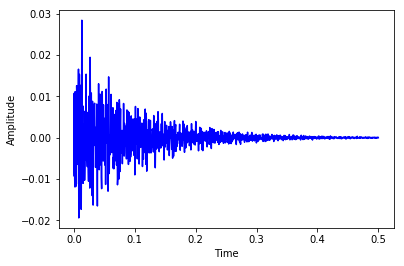

In [13]:
# Example plot of the raw data
t = np.linspace(0, 0.5, 1000)

plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.plot(t, ftms_data, 'b-')
plt.show()


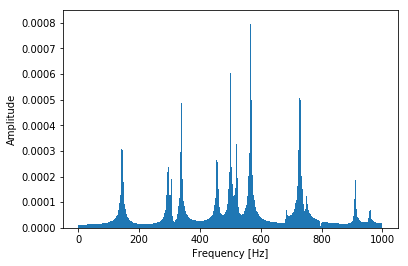

In [15]:
T = .5/1000 # sampling interval 
N = 1000
dft = discrete_fourier_transform(ftms_data)
plot_dft(T, N, dft)